In [9]:
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

#Import a few utility functions...
import sys  
from pathlib import Path
sys.path.insert(0, "../comm_channel")
sys.path.insert(0, "../polling_systems")
sys.path.insert(0, "../geometry")

#So we can import my local libs
import CommChannel as CC
import qos
import pointcloud as PC
import PollingSystem as PS
import MarkovianRP as MRP
import dtr

In [10]:
#setup quality of service requirements using reasonable values
F5GHz, F2_4GHz = 5, 2.4 #typical wifi frequencies are 2.4, 5, and sometiems 6 GHz
MOBILE_TX_POWER = qos.Pwr(30)#100-200mW (20-23 dBm) pretty typical, with 1W (30dBm) the absolute maximum
print(MOBILE_TX_POWER)
r = 6#any of 2, 4, 6, or 8
rx_noise = qos.Pwr(-85)#based on Yan and MostofiTWC13 #1e-10#this is in milliwatts
print(rx_noise)
BER = 1e-6
GAMMA_TH = qos.QoSReq(BER, r, rx_noise).thresholdChannelGain(MOBILE_TX_POWER)
print(GAMMA_TH)

30.000000 dBm	0.000000 dBW	1000.000000 mW	1.000000 W
-85.000000 dBm	-115.000000 dBW	0.000000 mW	0.000000 W
-87.90174759231483


Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.


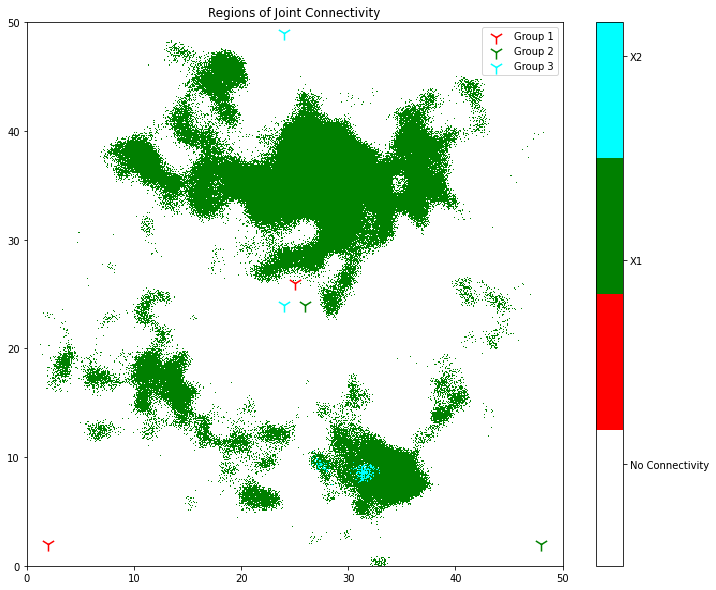

In [11]:
#Setup the system:

#For now, use same channel params, basd on the San Francisco measurements
nPL = 4.2  
kPL = -35

decorrSH = 3.09    
alpha = 8.41
sigmaSH = np.sqrt(alpha)
psdAtFC = 30

lam = 0.125
kRic = 10
decorrMP = 0.4*lam         
corrMP = 1
#sigmaMP = 3
sigmaMP = 1



#6 remote stations
qBase = np.array([[25,26], [2,2], [26,24], [48,2], [24, 24], [24,49]])
cps = [CC.ChannelParams(qBase[i], nPL, kPL, sigmaSH, decorrSH, decorrMP, lam,
                      kRic, corrMP, psdAtFC, sigmaMP) for i in range(len(qBase))]

x_max = 50
x_min = 0
y_max = 50
y_min = 0
region = [x_max, x_min, y_max, y_min]

#res = 2/decorrMP
res = 10
#Create Comm Channels
ccs = [CC.CommChannel(cps[i], region, res) for i in range(len(cps))]
for cc in ccs:
        cc.generateSH();cc.generateMP(2)

#now display the regions so we know if this is going to work for us
color_array=['white', 'red', 'green', 'cyan']
#plot the connectivity fields
cfs = [cc.getConnectionField(GAMMA_TH) for cc in ccs]
r1 = 1*cfs[0]*cfs[1]; r2 = 1*cfs[2]*cfs[3]; r3 = 1*cfs[4]*cfs[5];
cmap = ListedColormap(color_array)
ticks =[0.75/2,1.5-0.75/2, 1.5+0.75/2, 3-0.75/2]
tick_labels = ['No Connectivity','X1', 'X2', 'X3']
CC.plotField(region, r1+r2+r3, 'Regions of Joint Connectivity', cmap=cmap,
             ticks=ticks, tick_labels = tick_labels, do_show=False)

for i in range(3):
    plt.scatter([qBase[2*i][0], qBase[2*i+1][0]], [qBase[2*i][1], qBase[2*i+1][1]],
                label='Group %d'%(i+1), color=color_array[i+1], marker='1', s=200)
plt.legend()    
plt.show()

In [12]:
#Create the predicted channel
pct_sample = 0.005
n_samples = int(pct_sample*(x_max - x_min)*(y_max - y_min)*res**2)
print('Drawing %d samples from each region'%(n_samples))
pcs = []
for cc in ccs:
    xs, vals = cc.sampleChannel(n_samples)
    pcs.append(CC.PredictedChannel(cc.cp, cc.region, res, xs, vals))
    print('Completed PredictedChannel %d'%(len(pcs)))



Drawing 1250 samples from each region
Completed PredictedChannel 1
Completed PredictedChannel 2
Completed PredictedChannel 3
Completed PredictedChannel 4
Completed PredictedChannel 5
Completed PredictedChannel 6


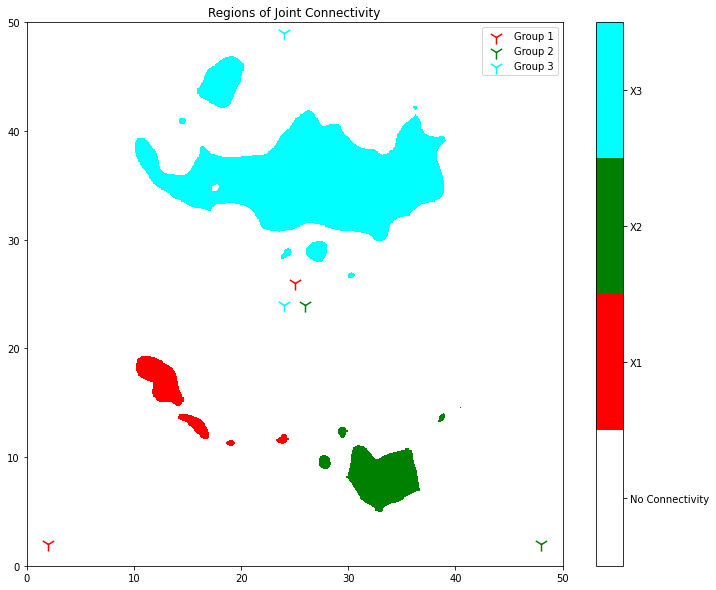

In [14]:
p_th = 0.7
for pc in pcs:
    pc.setPth(p_th)

#now display the regions so we know if this is going to work for us
color_array=['white', 'red', 'green', 'cyan']
#plot the connectivity fields
pfs = [pc.getPConField(GAMMA_TH) for pc in pcs]
r1 = 1*(pfs[0]*pfs[1]>p_th); r2 = 2*(pfs[2]*pfs[3]>p_th); r3 = 3*(pfs[4]*pfs[5]>p_th);
cmap = ListedColormap(color_array)
ticks =[0.75/2,1.5-0.75/2, 1.5+0.75/2, 3-0.75/2]
tick_labels = ['No Connectivity','X1', 'X2', 'X3']
CC.plotField(region, r1+r2+r3, 'Regions of Joint Connectivity', cmap=cmap,
             ticks=ticks, tick_labels = tick_labels, do_show=False)

for i in range(3):
    plt.scatter([qBase[2*i][0], qBase[2*i+1][0]], [qBase[2*i][1], qBase[2*i+1][1]],
                label='Group %d'%(i+1), color=color_array[i+1], marker='1', s=200)
plt.legend()    
plt.show()

In [5]:
pcs

In [29]:
from importlib import reload 
reload(dtr)
# reload(MRP)
# reload(PS)
reload(PC)

<module 'pointcloud' from '/home/win/dev/CommMotionPlanning/python/touring_relay/../geometry/pointcloud.py'>

Extracted edges...
Polygons constructed, looking for holes...
Constructed 4 possibly non-convex polygons
14 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 4 possibly non-convex polygons
15 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Found hole
Constructed 7 possibly non-convex polygons
51 total subregions
Optimized Policy Waiting Time: 89790.0926
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 1 logical processors, using up to 1 threads
Optimize a model with 425 rows, 89 columns and 1276 nonzeros
Model fingerprint: 0x9664760a
Model has 3 quadratic constraints
Variable types: 9 continuous, 80 integer (80 binary)
Coefficient statistics:
  Matrix range     [5e-02, 1e+04]
  QMatrix range    [1e+00, 2e+00]
  Objective range  [3e-02, 1e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range      

   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 1 logical processors, using up to 1 threads
Optimize a model with 425 rows, 89 columns and 1276 nonzeros
Model fingerprint: 0x4357cce8
Model has 3 quadratic constraints
Variable types: 9 continuous, 80 integer (80 binary)
Coefficient statistics:
  Matrix range     [5e-02, 1e+04]
  QMatrix range    [1e+00, 2e+00]
  Objective range  [7e-03, 1e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 58 rows and 0 columns
Presolve time: 0.09s
Presolved: 421 rows, 104 columns, 2521 nonzeros
Presolved model has 15 bilinear constraint(s)
Variable types: 24 continuous, 80 integer (80 binary)

Root relaxation: objective 0.000000e+00, 50 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000

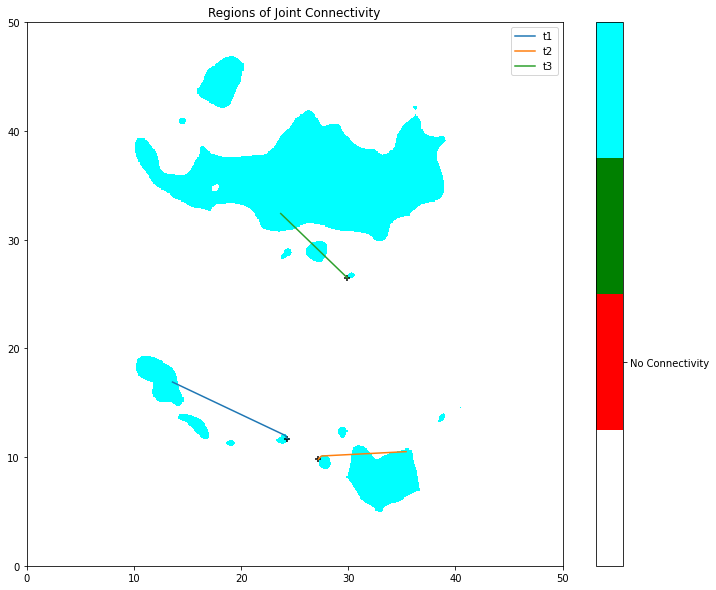

Optimized Waiting Time: 89767.0537


(array([0.8213474 , 0.11733446, 0.06131814]),
 array([[24.3, 11.7],
        [27.2,  9.8],
        [29.9, 26.5]]))

In [30]:
bandwidth = 2*1000000#give ourselfes 2MHz of BW
beta = 1/r*bandwidth
#make it easy to ensure stability by givein arrivals in terms of beta
els = [0.2/beta, 0.05/beta, 0.1/beta]
sys = dtr.DTR(pcs, els, beta, th=GAMMA_TH)
sys.optimize(x_opt_method=3)

Size of convex partition: 14
Size of convex partition: 15
Size of convex partition: 51


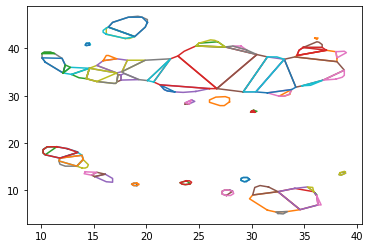

In [31]:
for reg in sys.cregions:
    n_cnvx = 0
    for p in reg.polygons:
        n_cnvx += len(p.cnvx_partition)
    print('Size of convex partition: %d'%(n_cnvx))
    reg.plot_polys()